# MPMS rock magnetic experiments data analysis

## Import scientific python libraries

In [277]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pandas as pd
import numpy as np
import scipy
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

%matplotlib inline

## Import data

In [278]:
NED2_8c_MPMS = pd.read_csv('./MPMS_data/NED2_8c_MPMS.csv')
NED2_8c_MPMS.head()

,experiment,T [K],Bapp [T],M [Am2/kg],reg fit,timestamp
0,FC,9.994304,0,0.015529,0.984894,1/8/2020 9:39:53 PM
1,FC,15.500260,0,0.014205,0.984457,1/8/2020 9:41:15 PM
2,FC,20.576900,0,0.013058,0.984438,1/8/2020 9:42:16 PM
3,FC,25.597500,0,0.012188,0.984445,1/8/2020 9:43:18 PM
4,FC,30.620950,0,0.011418,0.984483,1/8/2020 9:44:18 PM


In [279]:
def parse_MPMS_data(MPMS):
    if 'FC' in MPMS.experiment.unique():
        MPMS_FC = MPMS[MPMS.experiment == 'FC'].reset_index(drop = True)
    if 'ZFC' in MPMS.experiment.unique():   
        MPMS_ZFC = MPMS[MPMS.experiment == 'ZFC'].reset_index(drop = True)
    if 'RTSIRM_cooling' in MPMS.experiment.unique():
        MPMS_RTSIRM_cool = MPMS[MPMS.experiment == 'RTSIRM_cooling'].reset_index(drop = True)
    if 'RTSIRM_warming' in MPMS.experiment.unique():
        MPMS_RTSIRM_warm = MPMS[MPMS.experiment == 'RTSIRM_warming'].reset_index(drop = True)
    return MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm

def plot_mpms_dc(csv_file):
    MPMS = pd.read_csv(csv_file)
    MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm = parse_MPMS_data(MPMS)
    
    fig = plt.figure(figsize=(9,4.5))
    ax0 = fig.add_subplot(1,2,1)
    ax0.plot(MPMS_FC['T [K]'],MPMS_FC['M [Am2/kg]'],'.-',color='C1',label='FC')
    ax0.plot(MPMS_ZFC['T [K]'],MPMS_ZFC['M [Am2/kg]'],'.-',color='C2',label='ZFC')
    ax0.set_xlim(0,300)
    ax0.set_ylabel('M (Am2/kg)')
    ax0.legend()
    
    ax1 = plt.subplot(1,2,2)
    ax1.plot(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['M [Am2/kg]'],'.-',color='C0',label='RTSIRM cooling')
    ax1.plot(MPMS_RTSIRM_warm['T [K]'],MPMS_RTSIRM_warm['M [Am2/kg]'],'.-',color='C3',label='RTSIRM warming')
    ax1.set_xlim(0,300)
    ax1.set_ylabel('M (Am2/kg)')
    ax1.set_xlabel('T (K)')
    ax1.legend()
    
    fig.tight_layout()
    
    return fig

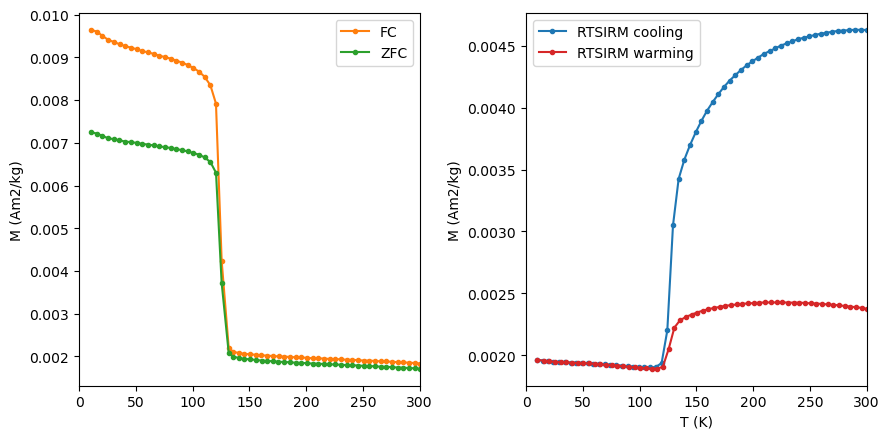

In [280]:
fig = plot_mpms_dc('./MPMS_data/NED34_6c_MPMS.csv')

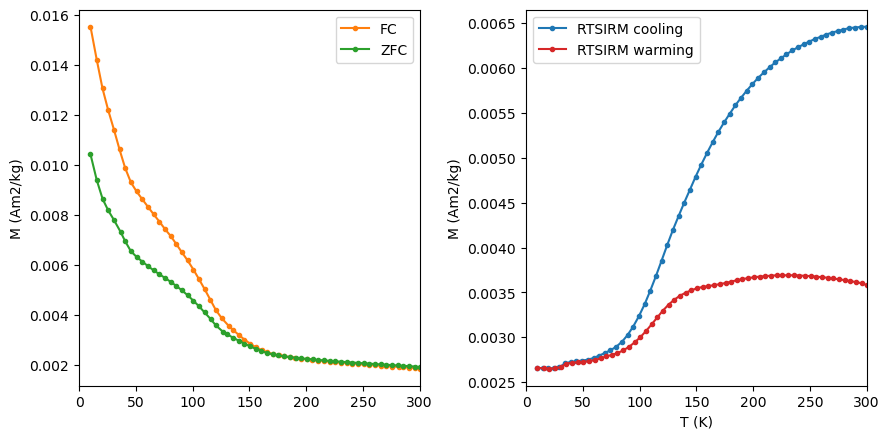

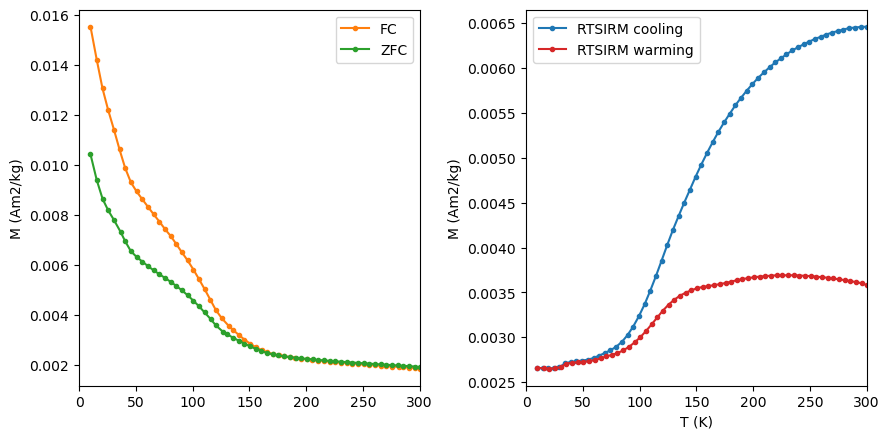

In [281]:
plot_mpms_dc('./MPMS_data/NED2_8c_MPMS.csv')

Its important to evaluate the derivative

In [282]:


def mpms_background_fit(temps, mags, t_range_background_min = 50, t_range_background_max = 250, excluded_t_min=75, excluded_t_max = 150, poly_deg = 3):

   
    dM = mags.diff()
    dT = temps.diff()

    dM_dT = dM/dT
    dM_dT = dM_dT[1:]

    temps_dM_dT = []
    for n in range(len(temps)-1):
        temps_dM_dT.append(mags[n] + dT[n+1]/2)
    temps = (temps.tolist())
    
#Error IS HERE ------------
    dM_dT = temps_dM_dT.copy() #Find the derivative mid point between make a new temperature list and new derivatie new data frame
    temps_filtered_indices = [i for i in np.arange(len(temps)) if ((float(temps[i]) > float(t_range_background_min)) and (float(temps[i])  < float(excluded_t_min)) ) or ((float(temps[i]) > float(excluded_t_max)) and (float(temps[i])  < float(t_range_background_max)))]
    temps_green_indices = [i for i in np.arange(len(temps)) if (float(temps[i]) > t_range_background_min and float(temps[i]) < excluded_t_min) or (float(temps[i]) > excluded_t_max and float(temps[i]) < t_range_background_max)]
    temps_filtered = [temp for temp in temps if ((float(temp) > float(t_range_background_min)) and (float(temp)  < float(excluded_t_min)) ) or ((float(temp) > float(excluded_t_max)) and (float(temp)  < float(t_range_background_max)))]
    temps_green = [temp for temp in temps if (float(temp) > t_range_background_min and float(temp) < excluded_t_min) or (float(temp) > excluded_t_max and float(temp) < t_range_background_max)]
    plots_of_derivatives_filtered = [dM_dT[index] for index in temps_filtered_indices]
    poly_background_fit_green = np.polyfit(temps_green, plots_of_derivatives_filtered, poly_deg)
    plots_of_polyfit = [np.poly1d(poly_background_fit_green)(temp) for temp in temps_green]
#Error IS HERE ------------
    
    fig = plt.figure(figsize=(9,4.5))
    mgt_array = []
    for i in np.arange(len(plots_of_polyfit)):
        mgt_array.append(plots_of_polyfit[i]-temps_dM_dT[i])

    print(temps_green)
    print(plots_of_polyfit)


#Sci-py instead of numpy
#Make another another plot (the one on the left of the picture)
#Write up a docstring -> Google formatted docstring (LOOK AT THE SCREENSHOT)

    ax2 = fig.add_subplot(1,2,1)
    ax2.set_xlabel('T[K]')
    ax2.set_ylabel('dM/dT [AM2/kgK]')
    ax2.plot(temps_green, plots_of_polyfit, color='green', label = 'bkg')
    ax2.plot(temps[1:], dM_dT, color='red', label = 'total')
    ax2.plot(temps_filtered,(mgt_array), color='blue', label = 'mgt')
    
    ax2.legend()

    x1_0 = temps
    y1_0 = mgt_array
    xpos1_0 = y1_0.index(max(y1_0)) #gets the x position of the max point
    xmax_0 = x1_0[xpos1_0]
    ymax_0 = dM_dT[xpos1_0]


    return xmax_0, ymax_0 #Returns the T [K] and dM/dT of the highest point in the red graph



In [283]:
def mpms_derivative(csv_file):
    MPMS = pd.read_csv(csv_file)
    MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm = parse_MPMS_data(MPMS)

    #calculate the derivative of each derivative of the 
    #Calculating the derivative is by finding the difference between the values on the y-axis, and dividing it by the values on the x-axis.

    # MPMS_FC['dM/dT [AM2/kgK]'] = (MPMS_FC['M [Am2/kg]'].diff()/2)/(MPMS_FC['T [K]'].diff()/2)
    # MPMS_ZFC['dM/dT [AM2/kgK]'] = (MPMS_ZFC['M [Am2/kg]'].diff()/2)/(MPMS_ZFC['T [K]'].diff()/2)
    # MPMS_RTSIRM_cool['dM/dT [AM2/kgK]'] = (MPMS_RTSIRM_cool['M [Am2/kg]'].diff()/2)/(MPMS_RTSIRM_cool['T [K]'].diff()/2)
    # MPMS_RTSIRM_warm['dM/dT [AM2/kgK]'] = (MPMS_RTSIRM_warm['M [Am2/kg]'].diff()/2)/(MPMS_RTSIRM_warm['T [K]'].diff()/2)


    #plot the mpms_derivative of each curve
    #Take the middle points  of dy and dx to represent the data
        
    #Builds the original plots
    # fig = plt.figure(figsize=(9,4.5))
    # ax2 = fig.add_subplot(1,2,1)
    # ax2.plot(MPMS_FC['T [K]'],MPMS_FC['dM/dT [AM2/kgK]'] ,'.-',color='C1',label='FC derivative')
    # ax2.plot(MPMS_ZFC['T [K]'],MPMS_ZFC['dM/dT [AM2/kgK]'],'.-',color='C2',label='ZFC derivative')
    # ax2.set_xlim(0,300)
    # ax2.set_xlabel('T[K]')
    # ax2.set_ylabel('dM/dT [AM2/kgK]')
    # ax2.legend()
    
    # ax3 = plt.subplot(1,2,2)
    # ax3.plot(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['dM/dT [AM2/kgK]'],'.-',color='C0',label='RTSIRM coolin derivative')
    # ax3.plot(MPMS_RTSIRM_warm['T [K]'],MPMS_RTSIRM_warm['dM/dT [AM2/kgK]'],'.-',color='C3',label='RTSIRM warming derivative')
    # ax3.set_xlim(0,300)
    # ax3.set_ylabel('dM/dT [AM2/kgK]')
    # ax3.set_xlabel('T (K)')
    # ax3.legend()

    # fig.tight_layout()




    #Show where the peak is for both the graphs
    xmax2_0, ymax2_0 = mpms_background_fit(MPMS_FC['T [K]'], MPMS_FC['M [Am2/kg]'])
    xmax3_0, ymax3_0 = mpms_background_fit(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['M [Am2/kg]'] )

    
    def plot_max_marker(graph, xmax, ymax):
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        graph.annotate(text, xy=(xmax, ymax), xytext=(0.,0.96), **kw)
    
    # plot_max_marker(ax2,xmax2_0, ymax2_0)
    # plot_max_marker(ax3,xmax3_0, ymax3_0)

    return fig
    
    

[50.52918, 55.58395, 60.57373, 65.59447, 70.54379, 150.6514, 155.4987, 160.5403, 165.6129, 170.5683, 175.6097, 180.4789, 185.5593, 190.5989, 195.486, 200.6205, 205.5646, 210.5388, 215.5426, 220.5572, 225.5516, 230.5386, 235.623, 240.4608, 245.4613]
[2.5124647842489845, 2.51488925919118, 2.5167111489882097, 2.5180110873898474, 2.518807746769113, 2.4969862019814, 2.4955114851915403, 2.494194552541051, 2.4931330270794967, 2.492390567977135, 2.4919738182674838, 2.4919331783159286, 2.4923096179880386, 2.493145766015069, 2.4944349946638535, 2.496337582750849, 2.4987395439753306, 2.501759395673056, 2.5054468444014764, 2.509835462905014, 2.514935576554538, 2.520793411046813, 2.5275934181057624, 2.5348771401523673, 2.5432781398264543]
[249.3443, 244.4171, 239.3248, 234.3218, 229.4391, 224.2507, 219.4034, 214.4155, 209.3004, 204.3531, 199.3296, 194.3426, 189.4081, 184.3658, 179.3132, 174.3457, 169.3353, 164.3845, 159.3067, 154.3828, 74.19812, 69.24815, 64.19468, 59.26421, 54.36507]
[-2.485150352

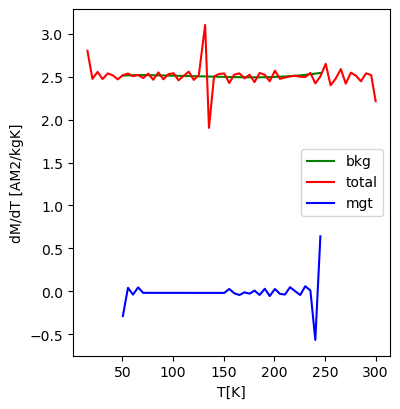

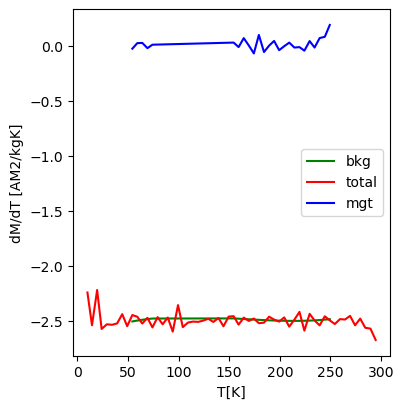

In [284]:
fig = mpms_derivative('./MPMS_data/NED34_6c_MPMS.csv')

[50.53382, 55.50077, 60.46664, 65.56294, 70.62476, 150.4723, 155.5616, 160.7314, 165.5742, 170.5424, 175.7764, 180.5024, 185.5623, 190.5595, 195.4939, 200.5383, 205.4929, 210.4608, 215.5735, 220.6407, 225.5464, 230.613, 235.5234, 240.4559, 245.5247]
[2.4971947897003064, 2.5023662200298875, 2.5068936298712714, 2.5109042513407522, 2.51428328316464, 2.5137542232581196, 2.511937530726926, 2.510075936725858, 2.5083483559324327, 2.5066233455505977, 2.504891926638795, 2.5034340478300674, 2.5020156673336595, 2.500790993302094, 2.4997846018366445, 2.498996133921846, 2.4984896227330835, 2.4982796127865567, 2.4984077588858997, 2.4989124639273994, 2.499790597219482, 2.501132010880871, 2.5028842616751734, 2.5051232071163843, 2.507956025611276]
[249.4446, 244.3904, 239.493, 234.4625, 229.3613, 224.4756, 219.4368, 214.4042, 209.4713, 204.3507, 199.4032, 194.4283, 189.3509, 184.3937, 179.3958, 174.3513, 169.311, 164.4746, 159.3946, 154.3464, 74.28511, 69.26963, 64.38036, 59.40144, 54.32656]
[-2.490513

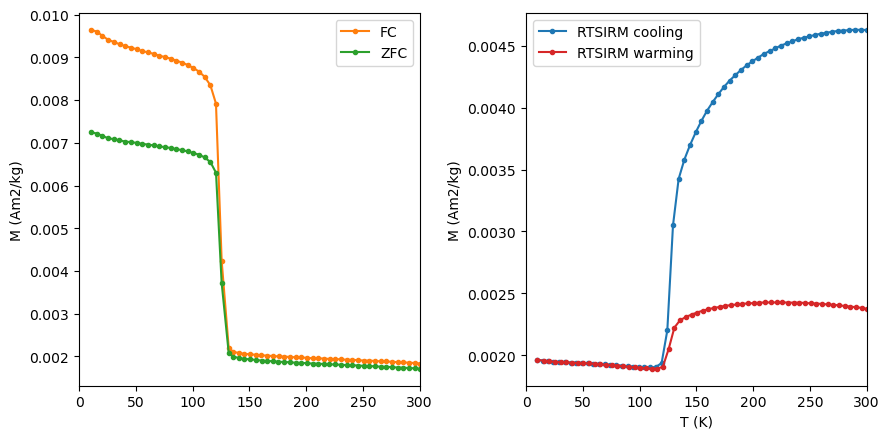

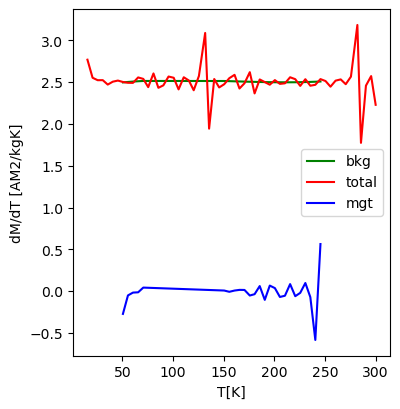

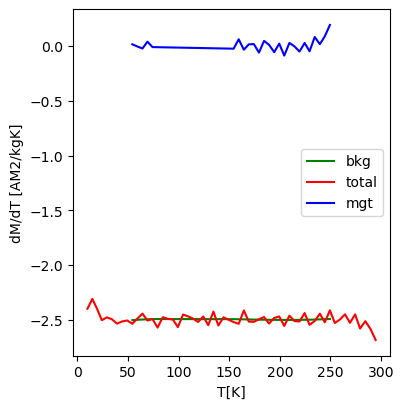

In [285]:
mpms_derivative('./MPMS_data/NED2_8c_MPMS.csv')
